In [1]:
import matplotlib.pyplot as plt
import pulp
import math
import random
import pandas as pd
import numpy as np

# 1. Utilities (Copied from Starter File made Availble in Project Folder Moodle page). All codes were gotten from Moodle Page

## 1.1. Points and Distances

In [2]:
def dist(p1, p2):
    (x1, y1) = p1
    (x2, y2) = p2
    return int(math.sqrt((x1-x2)**2+(y1-y2)**2))

## 1.2. Plot Map

In [3]:
def plotMap(G, T=[], P=[], W=None,
            style='r-o', lw=1, ms=3, 
            styleT='go', msT=5,
            styleP='b-o', lwP=3, msP=1,
            stylePT='go', msPT=7,
            styleW='bo', msW=9,
            text=None, grid=False):
    fig = plt.gcf()
    fig.set_size_inches(6, 6)
    V, E = G

    if not grid:
        plt.axis('off')
    plt.plot( [ p[0] for p in V ], [ p[1] for p in V ], 'ro', lw=lw, ms=ms)
    for (p, q) in E:
        plt.plot( [ p[0], q[0] ], [ p[1], q[1] ], 'r-o', lw=lw, ms=ms)
    for t in T:
        plt.plot( [ t[0] ], [ t[1] ], 
                  styleT, ms=msT)
    plt.plot( [ p[0] for p in P ],
              [ p[1] for p in P ], 
              styleP, lw=lwP, ms=msP)
    for p in P:
        if p in T:
            plt.plot( [ p[0] ], [ p[1] ], 
                      stylePT, ms=msPT)
    if W is not None:
        plt.plot( [ W[0] ], [ W[1] ], 
                      styleW, ms=msW)
    if text is not None:
        maxX = max([p[0] for p in V])
        plt.text(0.8*maxX, 0, text)
    if grid:
        plt.grid()
    plt.show()

## 1.3. Add Targets

In [4]:
def addTargets(M, T):
    V, E = M
    E = E.copy()
    V = V.copy()
    for t in T:
        minD = math.inf
        minE = None
        for e in E:
            P, Q = e
            distT = dist(P, t)+dist(t, Q)-dist(P, Q)
            if distT < minD:
                minD = distT
                minE = e
        P, Q = minE
        E.remove( (P, Q) )
        E.append( (P, t) )
        E.append( (t, Q) )
        V.append(t)
    return V, E

## 1.4. Generate Warehouse Location

This is a blind random generation as it would be needed for a Monte-Carlo Optimisation

In [5]:
def generateWarehouseLocation(M):
    V, _ = M
    W = random.sample(V, k=1)[0]
    return W

# 2. Load Pickled Sample Data

In [6]:
import pickle
with open('Data.pickled', 'rb') as f:
    M, C = pickle.load(f)

In [7]:
random.seed(5640)
W = generateWarehouseLocation(M)

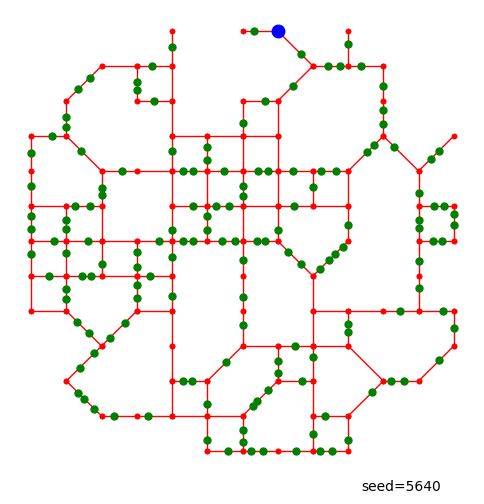

In [8]:
plotMap(M, T=C, P=[], W=W, text="seed=5640")

# 3. Finding the Shortest Path

## 3.1. The Algorithm 
I used the *A algorithm introduced in Week 3 available in Moodle page

In [9]:
def pathLength(P):
    return 0 if len(P)<=1 else \
            dist(P[0], P[1])+pathLength(P[1:])

In [10]:
def shortestPath(M, A, B):

    def h(p): 
        return pathLength(p)+dist(p[-1],B)
    
    # candidates C are pairs of the path so far and 
    # the heuristic function of that path, 
    # sorted by the heuristic function, as maintained by
    # insert function
    def insert(C, p):
        hp = h(p)
        c = (p, hp)
        for i in range(len(C)):
            if C[i][1]>hp:
                return C[:i]+[c]+C[i:]
        return C+[c]   
        
    V, E = M
    assert(A in V and B in V)    
    C = insert([], [A])

    while len(C)>0:
        # take the first candidate out of the list of candidates
        path, _ = C[0]
        C = C[1:]
        if path[-1]==B:
            return path
        else:
            for (x, y) in E:
                if path[-1]==x and y not in path:
                    C = insert(C, path+[y])
                elif path[-1]==y and x not in path:
                    C = insert(C, path+[x])
    return None

## 3.2 Testing

In [11]:
A = C[0]
B = C[-1]

In [12]:
MAB = addTargets(M, [A, B])

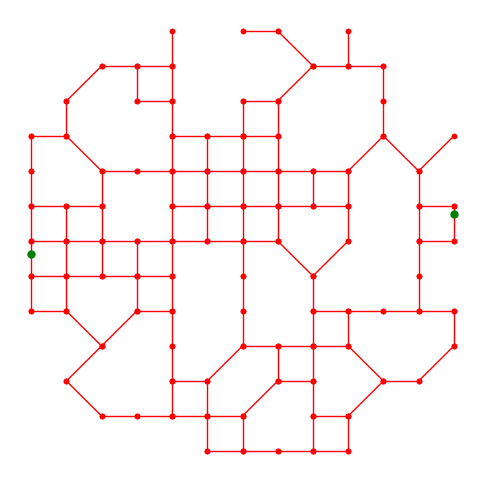

In [13]:
plotMap(MAB, T=[A, B])

In [14]:
P = shortestPath(MAB, A, B)

In [15]:
P

[(640, 3785),
 (640, 4000),
 (1200, 4000),
 (1760, 4000),
 (2320, 4000),
 (2880, 4000),
 (3440, 4000),
 (4000, 4000),
 (4560, 4000),
 (4560, 4560),
 (5120, 4560),
 (5680, 4560),
 (5680, 5120),
 (6240, 5680),
 (6800, 5120),
 (6800, 4560),
 (7360, 4560),
 (7360, 4428)]

In [16]:
pathLength(P)

9209

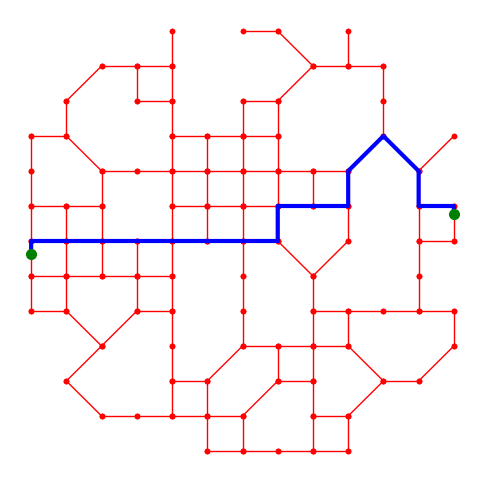

In [17]:
plotMap(MAB, T=[A, B], P=P)

# 4. Finding Shortest Delivery Route

## 4.1 Iterative Integer Programming 

In [18]:
def createTables(M, T):

    def reverse(P):
        return [ P[-i] for i in range(1,len(P)+1) ]
    
    def index(x, L):
        for i in range(len(L)):
            if x==L[i]: 
                return i
        return None

    n = len(T)
    d = [ [ math.inf for t in T ] for t in T ]
    p = [ [ None for t in T ] for t in T ]
    for i in range(n):
        d[i][i] = 0
        p[i][i] = [ T[i] ]
    for i in range(n):
        for j in range(n):
            if p[i][j] is None:
                s = shortestPath(M, T[i], T[j])
                d[i][j] = d[j][i] = pathLength(s)
                p[i][j] = s
                p[j][i] = reverse(s)
                for m in range(len(s)-1):
                    smi = index(s[m], T)
                    if smi is None:
                        continue
                    for l in range(m+1, len(s)):
                        sli = index(s[l], T)
                        if sli is None:
                            continue  
                        sub = s[m:l+1]
                        if p[smi][sli] is None:
                            p[smi][sli] = sub
                            p[sli][smi] = reverse(sub)
                            d[smi][sli] = d[sli][smi] = pathLength(sub)
    return d,p               

In [19]:
def roundtrips(x, n):
    
    def isElem(x, l):
        for i in range(len(l)):
            if l[i]==x:
                return True
        return False

    def startpoint(trips):
        for i in range(n):
            for t in trips:
                if isElem(i, t):
                    break
            else:
                return i
    
    def totalLength(trips):
        s=0
        for i in range(0, len(trips)):
            s += len(trips[i])-1
        return s

    trips = []
    while totalLength(trips)<n:
        start = startpoint(trips)
        trip = [ start ]
        i = start
        while len(trip) < n-totalLength(trips):
            for j in range(0, n):
                if pulp.value(x[i][j])==1:
                    trip.append(j)
                    i=j
                    break        
            if pulp.value(x[trip[-1]][start])==1:
                trip.append(start)
                break
        trips.append(trip)
    return sorted(trips, key=lambda t: len(t), reverse=True)

In [20]:
import time

def createLoop(M, T, timing=False):
    
    if timing:
        start_time = last_time = time.time()
        
    D, P = createTables(M, T)   # These are the distances between customers and warehouse only
    
    if timing:
        print(f"createTables:   {time.time()-start_time:6.2f}s")
        last_time = time.time()
        
    n = len(T)
    # create variables
    x = pulp.LpVariable.dicts("x", ( range(n), range(n) ),
                            lowBound=0, upBound=1, cat=pulp.LpInteger)
    # create problem
    prob = pulp.LpProblem("Loop",pulp.LpMinimize)
    # add objective function
    prob += pulp.lpSum([ D[i][j]*x[i][j] 
                             for i in range(n) for j in range(n) ])
    # add constraints
    constraints=0
    for j in range(n):
        prob += pulp.lpSum([ x[i][j] for i in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        prob += pulp.lpSum([ x[i][j] for j in range(n) if i!=j ]) ==1
    constraints += n
    for i in range(n):
        for j in range(n):
            if i!=j:
                prob += x[i][j]+x[j][i] <= 1
                constraints += 1
    # initialise solver
    solvers = pulp.listSolvers(onlyAvailable=True)
    solver = pulp.getSolver(solvers[0], msg=0)
    prob.solve(solver)

    if timing:
        print(f"Solver:         {time.time()-last_time:6.2f}s {constraints:6,d} Constraints")
        last_time = time.time()
        
    trips = roundtrips(x, n)
    while len(trips)>1:
        longest = max([ len(t) for t in trips ])
        for t in trips:
            if len(t)<longest:
                prob += pulp.lpSum([ x[t[i]][t[i+1]] + x[t[i+1]][t[i]]
                                        for i in range(0,len(t)-1) ]) <= len(t)-2
                constraints += 1
            else:
                longest = math.inf
        prob.solve(solver)
        
        if timing:
            print(f"Solver:         {time.time()-last_time:6.2f}s {constraints:6,d} Constraints")
            last_time = time.time()

        trips = roundtrips(x, n)
    trip = trips[0]
    # print(trip)
    loop = []
    for k in range(len(trip)-1):
        sub = P[trip[k]][trip[k+1]]
        loop += sub if len(loop)==0 else sub[1:]
        
    if timing:
        print(f"createLoop:     {time.time()-start_time:6.2f}s")

    return loop

## 4.2. Heuristic Solution

In [21]:
def FW(M):
    
    V, E = M

    n = len(V)
    d = [ [ math.inf for j in range(n) ] for i in range(n) ]
    p = [ [ None for j in range(n) ] for i in range(n) ]

    for (A, B) in E:
        a = V.index(A)
        b = V.index(B)
        d[a][b] = d[b][a] = dist(A, B)
        p[a][b] = [A, B]
        p[b][a] = [B, A]
    
    for i in range(n):
        d[i][i] = 0
        p[i][i] = [V[i]]
    
    for k in range(n):
        for i in range(n):
            for j in range(n):
                dk = d[i][k] + d[k][j]
                if d[i][j] > dk:
                    d[i][j] = dk
                    p[i][j] = p[i][k][:-1] + p[k][j]
                    
    return d, p

## 4.2.1. Greedy Algorithm 

In [22]:
def createLoopG(M, T, plot=False, timing=False):
    
    def makeLoop(L):
        loop = []
        for i in range(len(L)-1):
            A = L[i]
            B = L[i+1]
            a = V.index(A)
            b = V.index(B)
            sub = P[a][b]
            loop += sub if len(loop)==0 else sub[1:]
        return loop

    if timing:
        start_time = time.time()
        
    V, E = M
    D, P = FW(M)   # note these are the distances between all vertices in M (and T)
    
    if timing:
        print(f"Floyd-Warshall: {time.time()-start_time:6.2f}s")
        
    W = T[0]
    customers = T[1:]
    if len(T)==1:
        L = T
    elif len(T)<=3:
        L = T + [T[0]]
    else:
        L = T[:3]+[T[0]]
        T = T[3:]
        while len(T)>0:
            if plot:
                loop = makeLoop(L)
                plotMap(M, T=L, P=loop, w=W, 
                        grid=True, text=f"{pathLength(loop):,d}m")
            minExt = math.inf
            minInd = None
            selInd = None
            for k in range(len(T)):
                C = T[k]
                c = V.index(C)
                for i in range(0, len(L)-1):
                    A = L[i]
                    B = L[i+1]
                    a = V.index(A)
                    b = V.index(B)
                    ext = D[a][c] + D[c][b] - D[a][b]
                    if ext<minExt:
                        minExt, minInd, selInd = ext, i+1, k
            L = L[:minInd]+[T[selInd]]+L[minInd:]
            T = T[:selInd]+T[selInd+1:]
            
    if timing:
        print(f"createLoopG:    {time.time()-start_time:6.2f}s")
        
    return makeLoop(L)

## 4.2.2. Heuristic Algorithm
I incorporated the Heuristic Rule 2 and Rules 3 Available in Week 3 in Moodle to complete the Solution 

In [69]:
def createLoopH(M, T, plot=False, timing=False):
    
    def makeLoop(L):
        loop = []
        for i in range(len(L)-1):
            A = L[i]
            B = L[i+1]
            a = V.index(A)
            b = V.index(B)
            sub = P[a][b]
            loop += sub if len(loop)==0 else sub[1:]
        return loop

    if timing:
        start_time = time.time()
        
    V, E = M
    D, P = FW(M)   # note these are the distances between all vertices in M (and T)
    
    if timing:
        print(f"Floyd-Warshall: {time.time()-start_time:6.2f}s")
        
    W = T[0]
    customers = T[1:]
    if len(T)==1:
        L = T
    elif len(T)<=3:
        L = T + [T[0]]
    else:
        L = T[:3]+[T[0]]
        T = T[3:]
        while len(T)>0:
            if plot:
                loop = makeLoop(L)
                plotMap(M, T=L, P=loop, w=W, 
                        grid=True, text=f"{pathLength(loop):,d}m")
            minExt = math.inf
            minInd = None
            selInd = None
            for k in range(len(T)):
                C = T[k]
                c = V.index(C)
                for i in range(0, len(L)-1):
                    A = L[i]
                    B = L[i+1]
                    a = V.index(A)
                    b = V.index(B)
                    ext = D[a][c] + D[c][b] - D[a][b]
                    if ext<minExt:
                        minExt, minInd, selInd = ext, i+1, k
            L = L[:minInd]+[T[selInd]]+L[minInd:]
            T = T[:selInd]+T[selInd+1:]
            
    if timing:
        print(f"createLoopH:    {time.time()-start_time:6.2f}s")
        
    return makeLoop(L)

def shortcut2(roundtrip):
    #Attempt to shorten the route by reversing segments of the route."""
    n = len(roundtrip)
    best_route = roundtrip[:]
    for i in range(n - 1):
        for j in range(i + 2, n):  # ensure at least one node between i and j
            new_route = roundtrip[:i+1] + list(reversed(roundtrip[i+1:j+1])) + roundtrip[j+1:]
            if calculate_total_distance(new_route) < calculate_total_distance(best_route):
                best_route = new_route
    return best_route

def shortcut3(roundtrip):
    #Attempt to improve the route by repositioning nodes."""
    n = len(roundtrip)
    best_route = roundtrip[:]
    for i in range(1, n - 1):
        for j in range(n):
            if j != i and j != i + 1:  # Prevents index errors and unnecessary swaps
                new_route = roundtrip[:i] + roundtrip[i+1:]
                new_route.insert(j, roundtrip[i])
                if calculate_total_distance(new_route) < calculate_total_distance(best_route):
                    best_route = new_route
    return best_route

def calculate_total_distance(route):
    #Calculate the total distance of a route using the dist function."""
    return sum(dist(route[i], route[i + 1]) for i in range(len(route) - 1))

In [24]:
import pickle
with open('myData.pickled', 'rb') as f:
    M, C = pickle.load(f)

In [25]:
random.seed(5640)
W = generateWarehouseLocation(M)

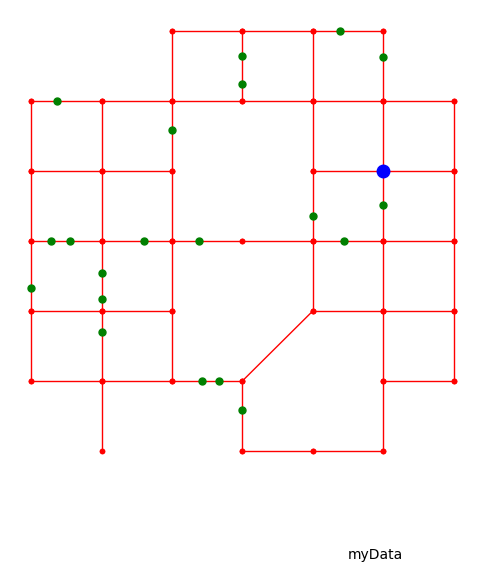

In [26]:
plotMap(M, T=C, P=[], W=W, text="myData")

## 4.3.1. Delivery to 10 Customer

In [27]:
random.seed(5640)
T = random.sample(C, k=len(C)//2)

In [28]:
MC = addTargets(M, T)

In [29]:
P = createLoop(MC, [W]+T)

In [30]:
PG = createLoopG(MC, [W]+T)

In [31]:
PH = createLoopH(MC, [W]+T)

In [32]:
W

(5760, 4880)

In [33]:
P

[(5760, 4880),
 (5760, 5760),
 (5760, 6317),
 (5760, 6640),
 (5224, 6640),
 (4880, 6640),
 (4000, 6640),
 (4000, 5973),
 (4000, 5760),
 (3120, 5760),
 (3120, 4880),
 (3120, 4000),
 (2768, 4000),
 (2240, 4000),
 (2240, 3268),
 (2240, 3120),
 (2240, 2853),
 (2240, 2240),
 (3120, 2240),
 (3499, 2240),
 (3709, 2240),
 (4000, 2240),
 (4880, 3120),
 (4880, 4000),
 (4880, 4314),
 (4880, 4000),
 (5760, 4000),
 (5760, 4456),
 (5760, 4880)]

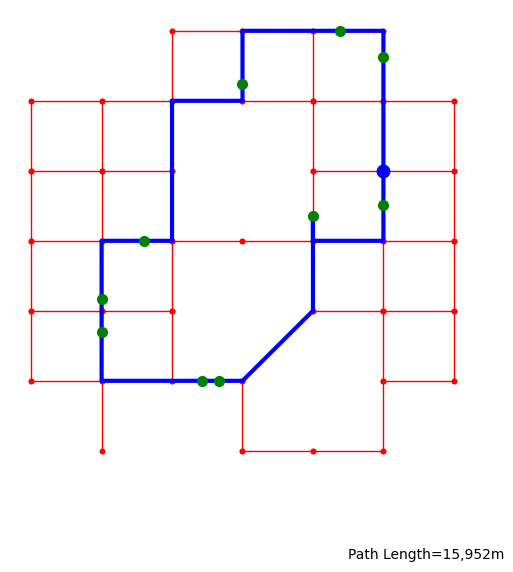

In [34]:
plotMap(MC, T=T, W=W, P=P, text=f"Path Length={pathLength(P):3,d}m")

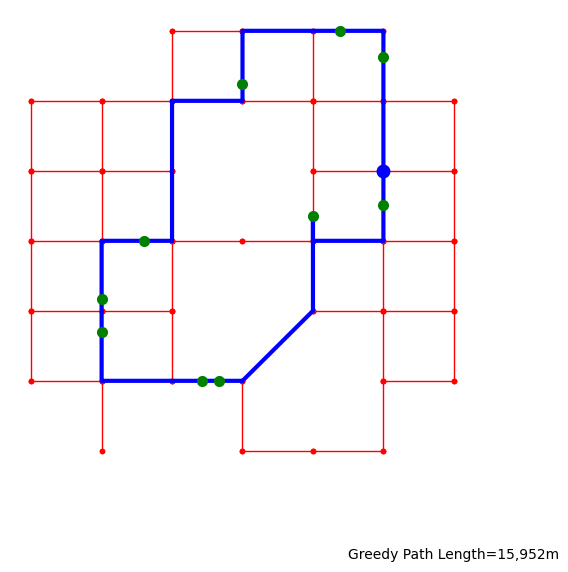

In [35]:
plotMap(MC, T=T, W=W, P=PG, text=f"Greedy Path Length={pathLength(PG):3,d}m")

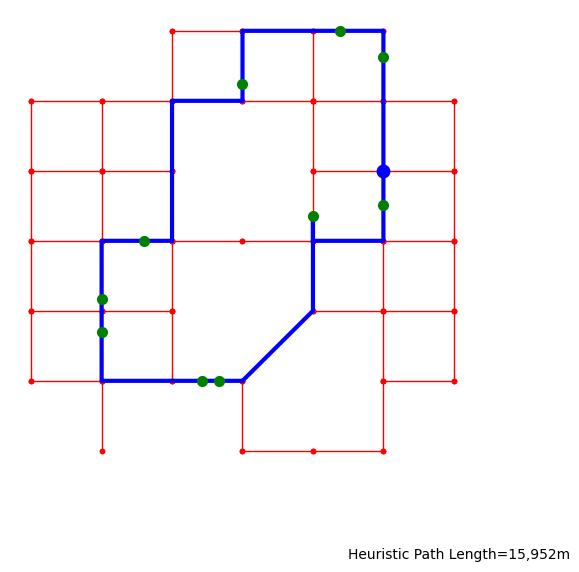

In [36]:
plotMap(MC, T=T, W=W, P=PH, text=f"Heuristic Path Length={pathLength(PH):3,d}m")

In [37]:
PH.reverse()

In [38]:
P == PH

True

## 4.3.2 Delivery to all Customers

In [39]:
T = C

In [40]:
MC = addTargets(M, T)

In [41]:
PC = createLoop(MC, [W] + T)

In [42]:
PCG = createLoopG(MC, [W]+T)

In [43]:
PCH = createLoopH(MC, [W]+T)

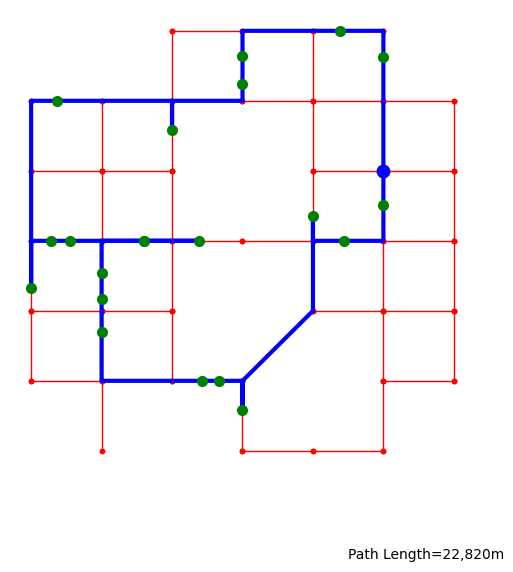

In [44]:
plotMap(MC, T=T, W=W, P=PC, text=f"Path Length={pathLength(PC):3,d}m")

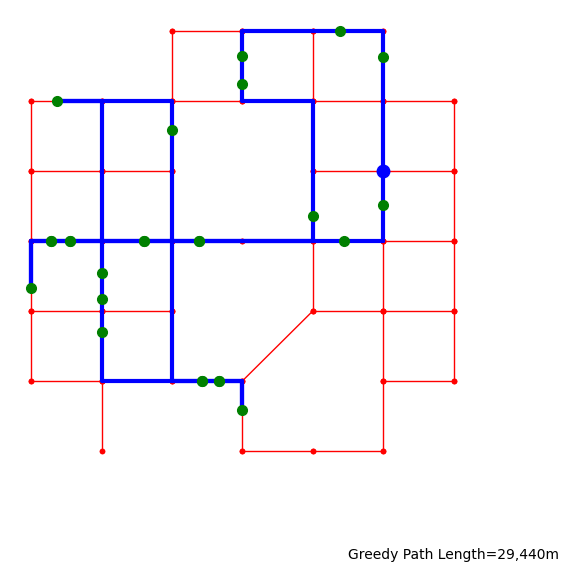

In [45]:
plotMap(MC, T=T, W=W, P=PCG, text=f"Greedy Path Length={pathLength(PCG):3,d}m")

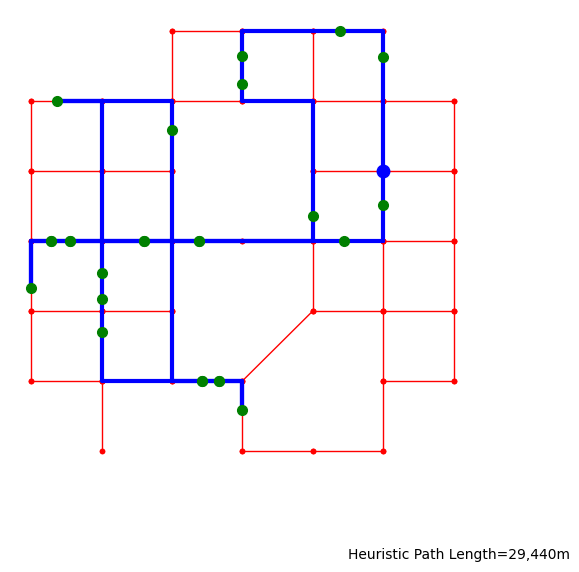

In [46]:
plotMap(MC, T=T, W=W, P=PCH, text=f"Heuristic Path Length={pathLength(PCH):3,d}m")

## 4.4. Running the Algorithm on Real Data

In [47]:
import pickle
with open('data.pickled', 'rb') as f:
    M, C = pickle.load(f)

In [48]:
random.seed(5640)
W1 = generateWarehouseLocation(M)

In [49]:
len(C)

150

In [50]:
random.seed(5640)
T = random.sample(C, k=len(C)//5)

In [51]:
MT = addTargets(M, T)

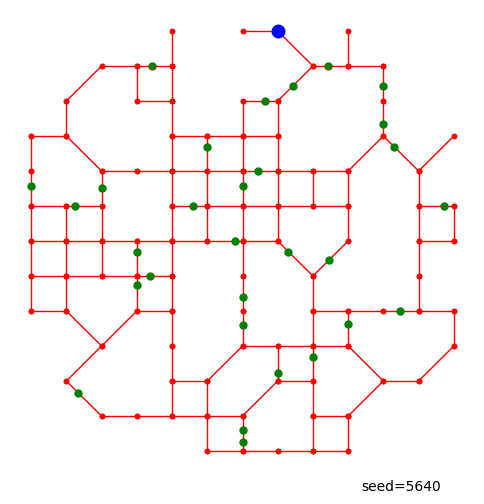

In [52]:
plotMap(MT, T=T, W=W1, P=[], text=f"seed=5640")

In [53]:
P1 = createLoop(MT, [W1]+T, timing=True)

createTables:     0.76s
Solver:           0.25s    992 Constraints
Solver:           0.15s    998 Constraints
createLoop:       1.16s


In [54]:
PG1 = createLoopG(MT, [W1]+T, timing=True)

Floyd-Warshall:   0.28s
createLoopG:      0.31s


In [55]:
PH1 = createLoopH(MT, [W1]+T, timing=True)

Floyd-Warshall:   0.28s
createLoopH:      0.31s


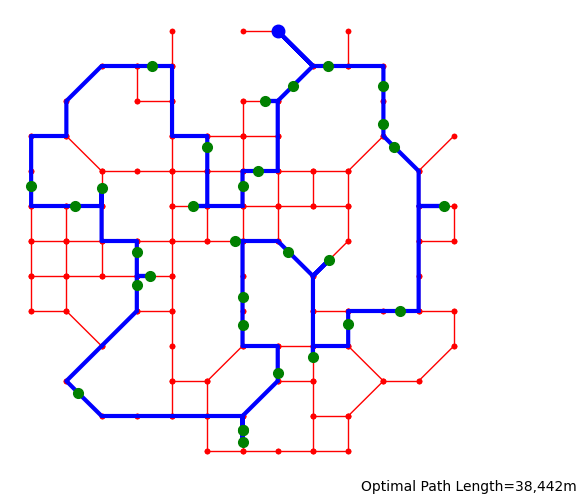

In [56]:
plotMap(MT, T=T, W=W1, P=P1, text=f"Optimal Path Length={pathLength(P1):3,d}m")

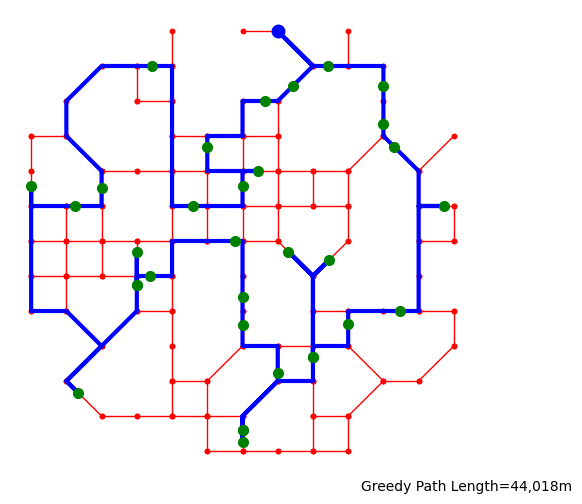

In [57]:
plotMap(MT, T=T, W=W1, P=PG1, text=f"Greedy Path Length={pathLength(PG1):3,d}m")

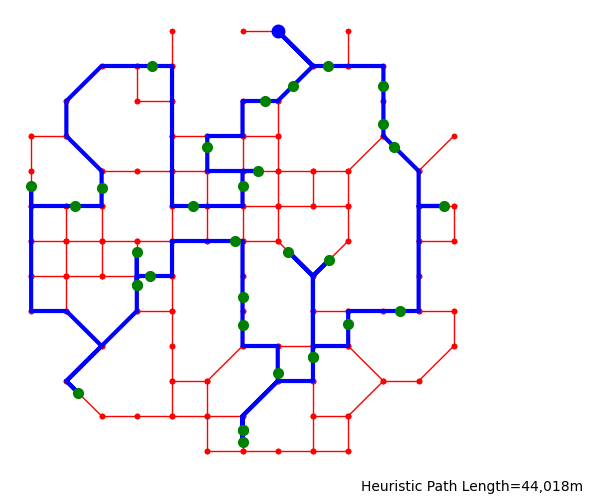

In [58]:
plotMap(MT, T=T, W=W1, P=PH1, text=f"Heuristic Path Length={pathLength(PH1):3,d}m")

In [72]:
random.seed(5640)
W2 = generateWarehouseLocation(M)

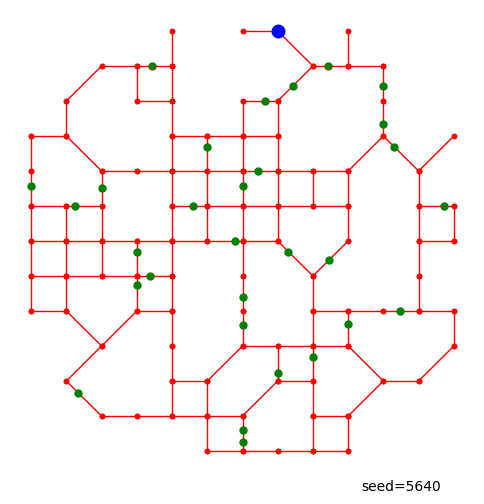

In [73]:
plotMap(MT, T=T, W=W2, P=[], text=f"seed=5640")

In [61]:
P2 = createLoop(MT, [W2]+T, timing=True)

createTables:     0.76s
Solver:           0.25s    992 Constraints
Solver:           0.16s    998 Constraints
createLoop:       1.17s


In [62]:
PG2 = createLoopH(MT, [W2]+T, timing=True)

Floyd-Warshall:   0.29s
createLoopH:      0.31s


In [63]:
PH2 = createLoopH(MT, [W2]+T, timing=True)

Floyd-Warshall:   0.29s
createLoopH:      0.31s


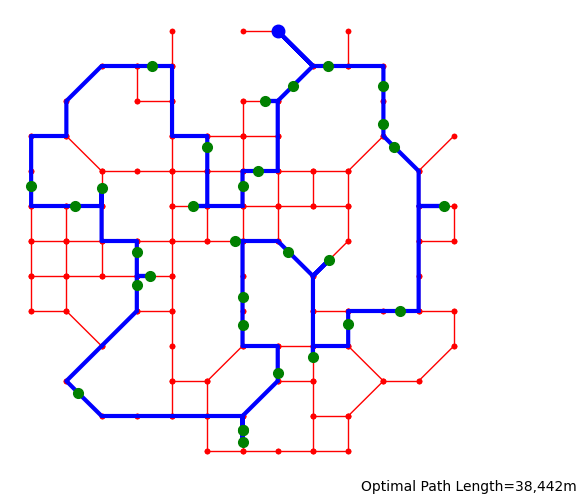

In [64]:
plotMap(MT, T=T, W=W2, P=P2, text=f"Optimal Path Length={pathLength(P2):3,d}m")

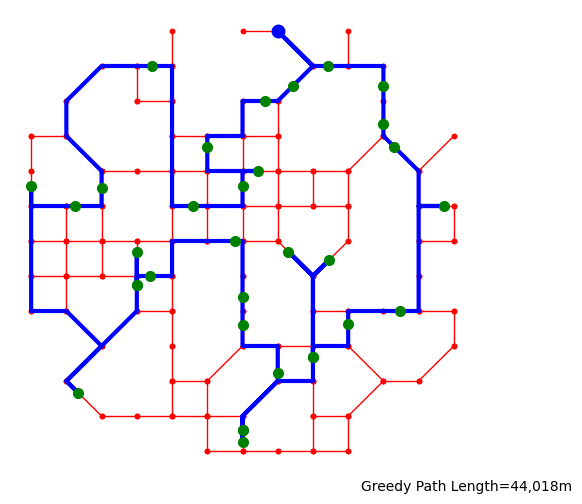

In [65]:
plotMap(MT, T=T, W=W2, P=PG2, text=f"Greedy Path Length={pathLength(PG2):3,d}m")

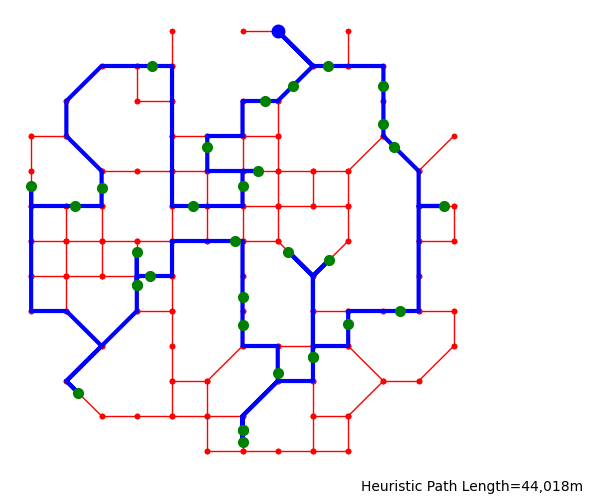

In [66]:
plotMap(MT, T=T, W=W2, P=PH2, text=f"Heuristic Path Length={pathLength(PH2):3,d}m")

# 5. Monte-Carlo Optimasation
This is an optimisation for the case of a fixed given number of customers to be served in one loop.

In [67]:
def monte_carlo(M, T, k=math.inf, timing=False, plot=False):
    if timing:
        start_time = time.time()
    V, _ = M
    W = sorted(random.sample(V, k=min(len(V), k)))
    MT = addTargets(M, T)
    minL, minP, minW = math.inf, None, None
    for w in W:
        if minP is not None and w in minP:
            # any point on the current shortest loop will generate the same loop
            continue
        P = createLoop(MT, [w]+T)
        L = pathLength(P)
        if L<minL:
            minL, minP, minW = L, P, w
            print(f"pathlength: {L:6,d}m")
        if timing:
            print(f"     iteration:  {time.time()-start_time:6.2f}s")
    plotMap(MT, T=T, W=minW, P=minP, text=f"seed=5640 Path Length={minL:8.1f}m")
    return minW

pathlength: 39,053m
     iteration:    5.12s
pathlength: 36,860m
     iteration:    6.85s
     iteration:   10.36s
     iteration:   13.06s
     iteration:   14.96s
     iteration:   16.78s
     iteration:   18.45s
     iteration:   20.13s
     iteration:   21.76s
     iteration:   23.42s
     iteration:   25.19s
     iteration:   26.79s
     iteration:   28.49s
     iteration:   30.07s
     iteration:   31.87s
     iteration:   33.55s
     iteration:   35.31s
     iteration:   36.92s
     iteration:   38.73s
     iteration:   40.36s
     iteration:   41.80s
     iteration:   43.19s
     iteration:   44.63s
     iteration:   46.28s
     iteration:   47.89s
     iteration:   49.69s
     iteration:   51.32s
     iteration:   52.85s
     iteration:   54.43s
     iteration:   56.05s
     iteration:   57.85s
     iteration:   59.53s
     iteration:   61.44s
     iteration:   63.12s
     iteration:   64.70s
     iteration:   66.59s
     iteration:   68.39s
     iteration:   69.81s
     itera

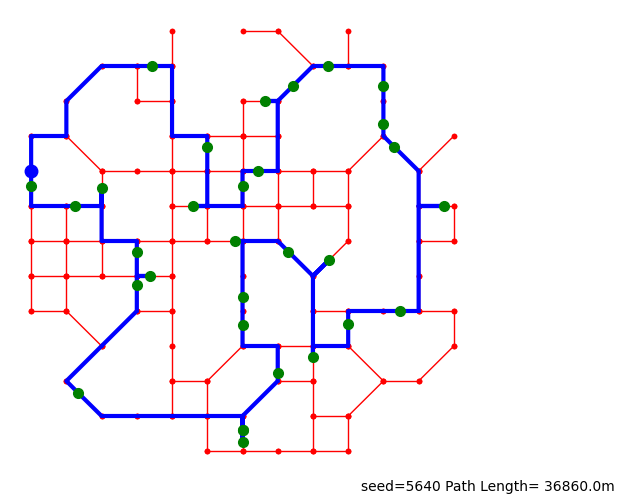

(640, 5120)

In [68]:
random.seed(5640)
monte_carlo(M, T, timing=True, plot=True)